<a href="https://colab.research.google.com/github/alecbidaran/Generative-deep-learning/blob/main/Satellite_image_segmentaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tfds-nightly tensorflow matplotlib

     |████████████████████████████████| 3.9MB 32.2MB/s 


In [2]:
%tensorflow_version 2.x
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add, concatenate, Lambda, Flatten, Conv2DTranspose,DepthwiseConv2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras as keras 
import tensorflow as tf
import numpy as np 
import tensorflow_datasets as tdfs


In [3]:
dataset,metadata=tdfs.load('eurosat/rgb',split='train', with_info=True,as_supervised=True)

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


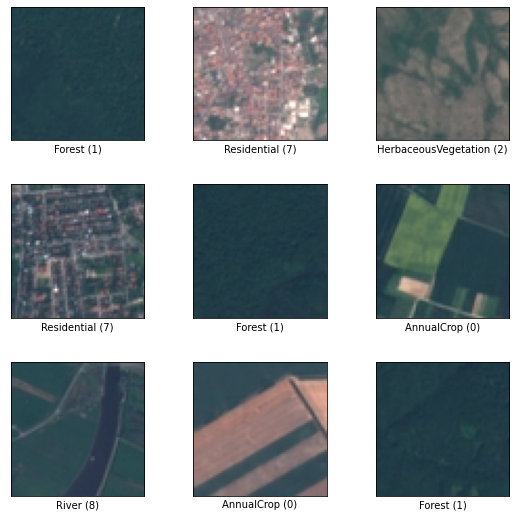

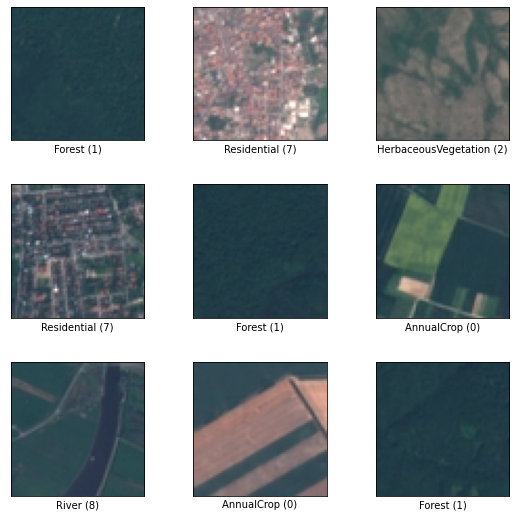

In [ ]:
tdfs.show_examples(dataset,metadata)

In [4]:
train=tdfs.as_numpy(dataset)
array=np.vstack(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [5]:
X_train = np.array(list(map(lambda x: x[0], array)))
Y_train=np.array(list(map(lambda x: x[1], array)))

In [6]:
X_train=X_train.astype(np.float32)/255

In [7]:
X_train.shape

(27000, 64, 64, 3)

In [ ]:
def normalize(image_input):
  input_image=tf.cast(image_input,dtype=tf.float32)
  input_image=input_image/255
  return input_image


In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((X_train))

In [ ]:
train_dataset=train_dataset.map(normalize,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset=train_dataset.shuffle(100).batch(32)

In [ ]:
#@markdown ### 3.5. Define loss and model
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add, concatenate, Lambda, Flatten, Conv2DTranspose
from tensorflow.keras.optimizers import RMSprop

# LOSS
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


#MODEL
def unet_tiny(input_shape=(64,64, 3), init_nb=16, lr=0.0001, loss=bce_dice_loss, num_classes=3):
    
    inputs = Input(input_shape)
    
    down1 = Conv2D(init_nb, (5,5), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1pool = Conv2D(init_nb, (5,5), padding='same', strides=(2, 2))(down1)
    down1pool = BatchNormalization()(down1pool)
    down1pool = Activation('relu')(down1pool)
    
    down2 = Conv2D(init_nb * 2, (5,5), padding='same')(down1pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2pool = Conv2D(init_nb * 2, (5,5), padding='same', strides=(2, 2))(down2)
    down2pool = BatchNormalization()(down2pool)
    down2pool = Activation('relu')(down2pool)

    down3 = Conv2D(init_nb * 4, (5,5), padding='same')(down2pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3pool = Conv2D(init_nb * 4, (5,5), padding='same', strides=(2, 2))(down3)
    down3pool = BatchNormalization()(down3pool)
    down3pool = Activation('relu')(down3pool)
    
    # stacked dilated convolution
    dilate1 = Conv2D(init_nb * 8, (5,5), padding='same', dilation_rate=1)(down3pool)
    dilate1 = BatchNormalization()(dilate1)
    dilate1 = Activation('relu')(dilate1)
    dilate2 = Conv2D(init_nb * 8, (5,5), padding='same', dilation_rate=2)(dilate1)
    dilate2 = BatchNormalization()(dilate2)
    dilate2 = Activation('relu')(dilate2)
    dilate3 = Conv2D(init_nb * 8, (5,5), padding='same', dilation_rate=4)(dilate2)
    dilate3 = BatchNormalization()(dilate3)
    dilate3 = Activation('relu')(dilate3)
    dilate4 = Conv2D(init_nb * 8, (5,5), padding='same', dilation_rate=8)(dilate3)
    dilate4 = BatchNormalization()(dilate4)
    dilate4 = Activation('relu')(dilate4)
    
    dilate_all_added = add([dilate1, dilate2, dilate3, dilate4])
    
    up3 = Conv2DTranspose(init_nb * 4,(5,5), padding='same', strides=(2, 2))(dilate_all_added)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = add([down3, up3])
    up3 = Conv2D(init_nb * 4, (5,5), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    
    up2 = Conv2DTranspose(init_nb * 2, (5,5), padding='same', strides=(2, 2))(up3)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = add([down2, up2])
    up2 = Conv2D(init_nb * 2, (5,5), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    
    up1 = Conv2DTranspose(init_nb,(5,5), padding='same', strides=(2, 2))(up2)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = add([down1, up1])
    up1 = Conv2D(init_nb, (5,5), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    
    classify = Conv2D(num_classes, (1, 1), activation='softmax')(up1)

    model = Model(inputs=inputs, outputs=classify)
    return model

In [ ]:
model=unet_tiny()
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 64, 64, 16)   1216        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 64, 64, 16)   64          conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 64, 64, 16)   0           batch_normalization_32[0][0]     
____________________________________________________________________________________________

In [ ]:
model.fit(X_train,X_train,epochs=50,verbose=1,batch_size=64)

Epoch 1/50
422/422 [==============================] - 24s 54ms/step - loss: 1.3916 - accuracy: 0.6185
Epoch 2/50
422/422 [==============================] - 23s 54ms/step - loss: 1.2966 - accuracy: 0.6157
Epoch 3/50
422/422 [==============================] - 23s 54ms/step - loss: 1.3088 - accuracy: 0.6184
Epoch 4/50
422/422 [==============================] - 23s 54ms/step - loss: 1.3053 - accuracy: 0.6129
Epoch 5/50
422/422 [==============================] - 23s 54ms/step - loss: 1.2977 - accuracy: 0.6141
Epoch 6/50
422/422 [==============================] - 23s 54ms/step - loss: 1.3184 - accuracy: 0.5900
Epoch 7/50
422/422 [==============================] - 23s 55ms/step - loss: 1.3212 - accuracy: 0.6011
Epoch 8/50
422/422 [==============================] - 23s 55ms/step - loss: 1.3121 - accuracy: 0.6170
Epoch 9/50
422/422 [==============================] - 23s 54ms/step - loss: 1.3203 - accuracy: 0.6188
Epoch 10/50
422/422 [==============================] - 23s 54ms/step - loss: 1.317

In [ ]:
img=model.predict(X_train[:1000])

In [ ]:
img

array([[[[0.21211039, 0.34007502, 0.44781464],
         [0.21082622, 0.34010866, 0.44906512],
         [0.2144554 , 0.3283426 , 0.45720202],
         ...,
         [0.20732503, 0.33804095, 0.45463398],
         [0.21382742, 0.3340835 , 0.4520891 ],
         [0.2209229 , 0.33668542, 0.44239166]],

        [[0.20865901, 0.33794162, 0.4533994 ],
         [0.2065761 , 0.33828542, 0.45513847],
         [0.20590861, 0.3272618 , 0.46682963],
         ...,
         [0.20361938, 0.3342696 , 0.4621111 ],
         [0.20639016, 0.33295378, 0.46065608],
         [0.21423687, 0.33433613, 0.451427  ]],

        [[0.21574797, 0.33819693, 0.44605508],
         [0.20491852, 0.33528084, 0.45980063],
         [0.2139451 , 0.32842952, 0.45762536],
         ...,
         [0.21354082, 0.33657733, 0.4498819 ],
         [0.20631614, 0.33734575, 0.4563381 ],
         [0.20561682, 0.3421858 , 0.45219734]],

        ...,

        [[0.21613225, 0.33367455, 0.45019317],
         [0.20749497, 0.3412304 , 0.4512747 ]

In [16]:
import matplotlib.pyplot as plt 
import numpy as np 
import cv2 

**Using U-net**

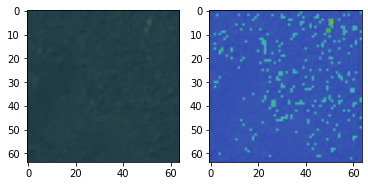

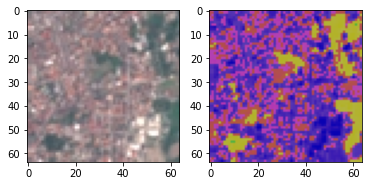

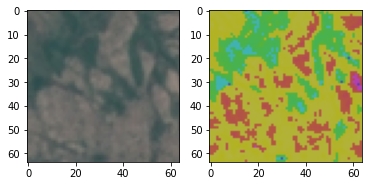

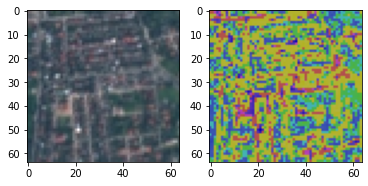

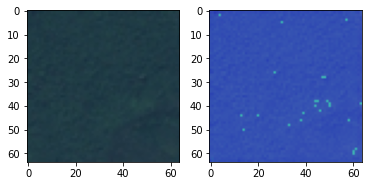

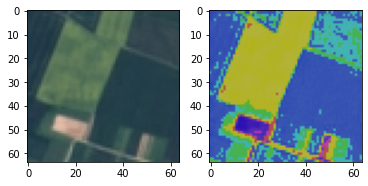

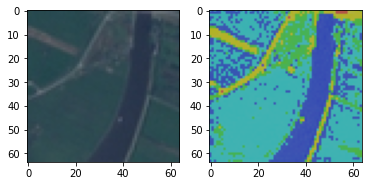

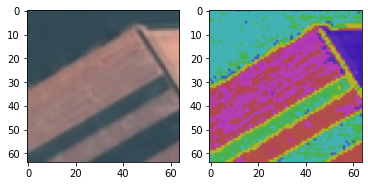

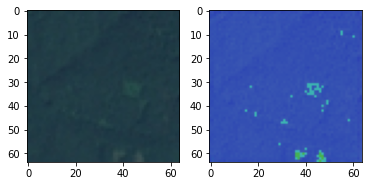

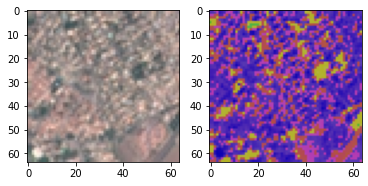

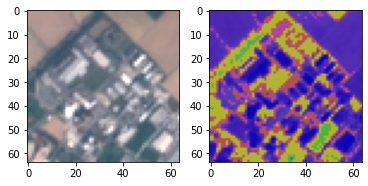

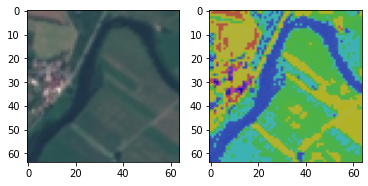

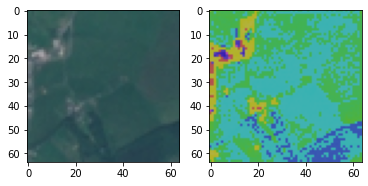

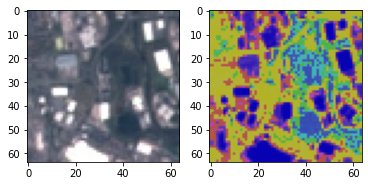

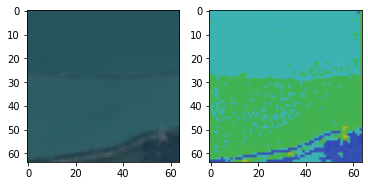

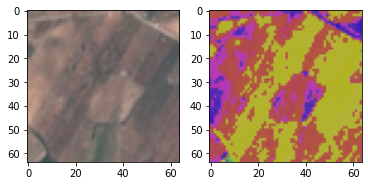

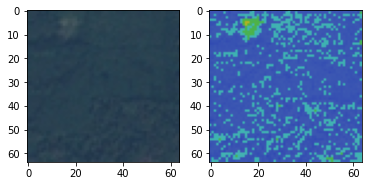

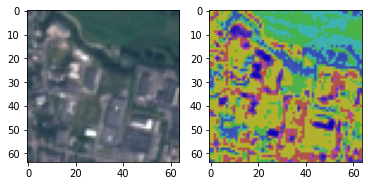

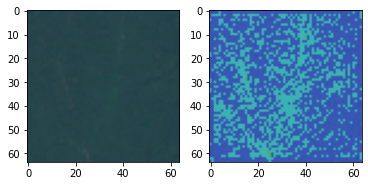

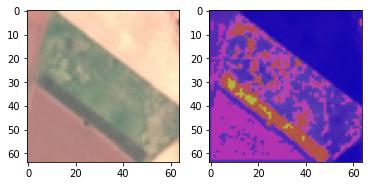

In [ ]:
for i in range(20):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(X_train[i])
  plt.subplot(1,2,2)
  img[i][img[i]>=0.35]=0.70

  plt.imshow(img[i])

/usr/local/lib/python3.6/dist-packages/matplotlib/cm.py:229: RuntimeWarning: invalid value encountered in multiply
  xx = (xx * 255).astype(np.uint8)


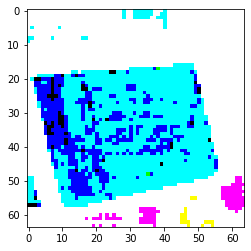

In [ ]:
img2=cv2.bitwise_or(X_train[1000],img[0]*255)
plt.imshow(img2)

In [92]:
#@markdown creating model 
def create_model1():
  init_nb=16
  num_classes=3
  inputs = Input((64,64,num_classes))
  down1 = Conv2D(init_nb, (5,5), padding='same')(inputs)
  down1 = BatchNormalization()(down1)
  down1=MaxPooling2D(pool_size=(2,2))(down1)
  down1pool = Conv2D(init_nb, (5,5), padding='same', strides=(2, 2))(down1)
  down1pool = BatchNormalization()(down1pool)
  down1pool = Activation('relu')(down1pool)
  down1pool=MaxPooling2D(pool_size=(2,2))(down1pool)

  down2 = Conv2D(init_nb * 2, (5,5), padding='same')(down1pool)
  down2 = BatchNormalization()(down2)
  down2 = Activation('relu')(down2)
  down2pool = Conv2D(init_nb * 2, (5,5), padding='same', strides=(2, 2))(down2)
  down2pool = BatchNormalization()(down2pool)
  down2pool = Activation('relu')(down2pool)
  down2pool=MaxPooling2D(pool_size=(2,2))(down2pool)


  down3 = Conv2D(init_nb * 4, (5,5), padding='same')(down2pool)
  down3 = BatchNormalization()(down3)
  down3 = Activation('relu')(down3)
  down3pool = Conv2D(init_nb * 4, (5,5), padding='same', strides=(2, 2))(down3)
  down3pool = BatchNormalization()(down3pool)
  down3pool = Activation('relu')(down3pool)

    
  up3 = UpSampling2D(size=(4,4))(down3pool)
  up3 = BatchNormalization()(up3)
  up3 = Activation('relu')(up3)
  up3 = Conv2D(init_nb * 4, (5,5), padding='same')(up3)
  up3 = Conv2D(init_nb * 4, (3, 3), padding='same')(up3)
  up3 = BatchNormalization()(up3)
  up3 = Activation('relu')(up3)
    
  up2 =UpSampling2D(size=(4,4))(up3)
  up2 = BatchNormalization()(up2)
  up2 = Activation('relu')(up2)
  up2 = Conv2D(init_nb * 2, (5,5), padding='same')(up2)
  up2 = Conv2D(init_nb * 2, (3, 3), padding='same')(up2)
  up2 = BatchNormalization()(up2)
  up2 = Activation('relu')(up2)
    
  up1 =UpSampling2D(size=(4,4))(up2)
  up1 = BatchNormalization()(up1)
  up1 = Activation('relu')(up1)
  up1 = Conv2D(init_nb, (5,5), padding='same')(up1)
  up1 = Conv2D(init_nb, (3, 3), padding='same')(up1)
  up1 = BatchNormalization()(up1)
  up1 = Activation('relu')(up1)
  classify = Conv2D(3, (1,1), activation='softmax')(up1)
  model1 = Model(inputs=inputs, outputs=classify)
  return model1


In [93]:
disturbution=tf.distribute.experimental.CentralStorageStrategy()
with disturbution.scope():
  model1=create_model1()
  model1.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  model1.summary()


INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:GPU:0'


INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:GPU:0'


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 16)        1216      
_________________________________________________________________
batch_normalization_36 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 16)        6416      
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
activation_33 (Activation)   (None, 16, 16, 16)        0   

In [94]:
model1.fit(X_train,X_train,epochs=20,verbose=1,batch_size=64)

Epoch 1/20
422/422 [==============================] - 18s 31ms/step - loss: 1.2875 - accuracy: 0.4550
Epoch 2/20
422/422 [==============================] - 13s 30ms/step - loss: 1.3423 - accuracy: 0.5622
Epoch 3/20
422/422 [==============================] - 13s 30ms/step - loss: 1.3818 - accuracy: 0.6115
Epoch 4/20
422/422 [==============================] - 13s 30ms/step - loss: 1.4036 - accuracy: 0.6328
Epoch 5/20
422/422 [==============================] - 13s 30ms/step - loss: 1.4117 - accuracy: 0.6434
Epoch 6/20
422/422 [==============================] - 12s 29ms/step - loss: 1.3948 - accuracy: 0.6268
Epoch 7/20
422/422 [==============================] - 12s 29ms/step - loss: 1.3831 - accuracy: 0.6195
Epoch 8/20
422/422 [==============================] - 12s 29ms/step - loss: 1.3527 - accuracy: 0.5595
Epoch 9/20
422/422 [==============================] - 12s 29ms/step - loss: 1.3329 - accuracy: 0.5453
Epoch 10/20
422/422 [==============================] - 13s 30ms/step - loss: 1.312

In [72]:
test=X_train[:1000]
img1=model1.predict(test)
img1

array([[[[0.16940047, 0.47162834, 0.35897118],
         [0.2270819 , 0.3657219 , 0.4071962 ],
         [0.28989616, 0.32530302, 0.38480082],
         ...,
         [0.2561893 , 0.3584732 , 0.3853375 ],
         [0.29276705, 0.3283642 , 0.37886873],
         [0.3301904 , 0.28771606, 0.38209355]],

        [[0.23375317, 0.403495  , 0.36275178],
         [0.24919257, 0.35279328, 0.39801422],
         [0.27774426, 0.33551463, 0.38674107],
         ...,
         [0.23758943, 0.3580599 , 0.40435064],
         [0.24697404, 0.35136384, 0.40166214],
         [0.27224052, 0.32854515, 0.39921436]],

        [[0.27670857, 0.35599545, 0.36729598],
         [0.26888657, 0.36466426, 0.36644918],
         [0.26955023, 0.36165836, 0.36879143],
         ...,
         [0.25165352, 0.3670487 , 0.38129774],
         [0.28024116, 0.3450393 , 0.37471953],
         [0.25938886, 0.3668702 , 0.3737409 ]],

        ...,

        [[0.23958418, 0.3603616 , 0.40005425],
         [0.25982508, 0.35203114, 0.3881438 ]

**Using Upsampling2D**

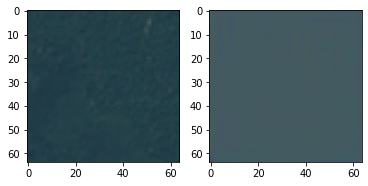

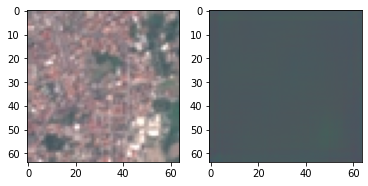

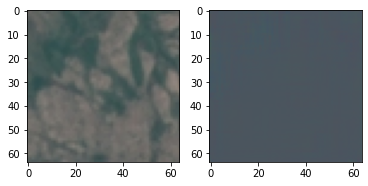

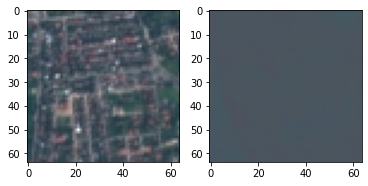

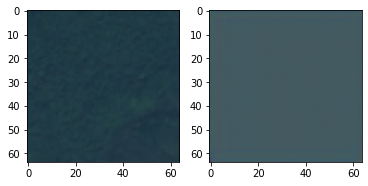

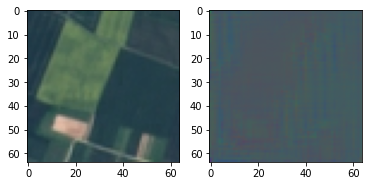

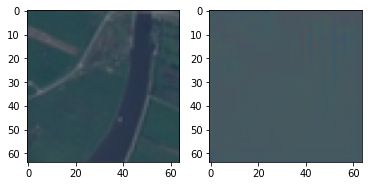

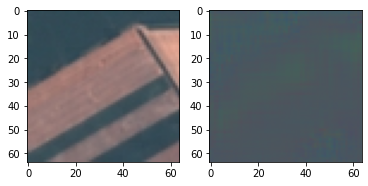

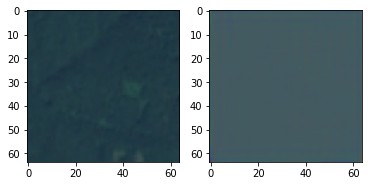

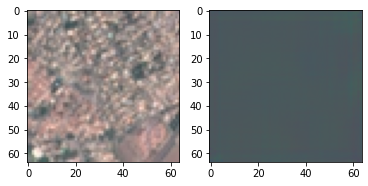

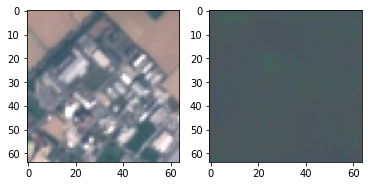

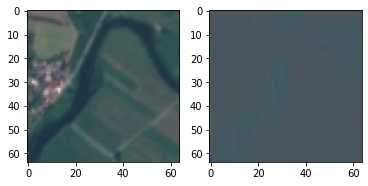

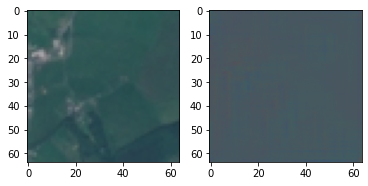

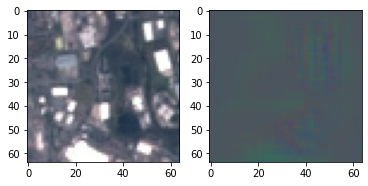

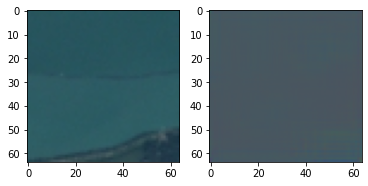

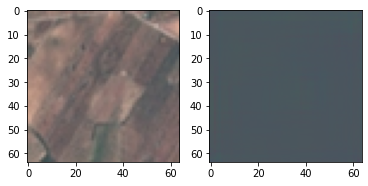

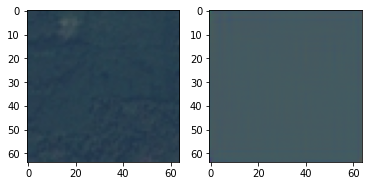

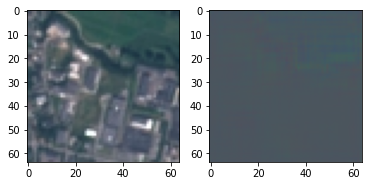

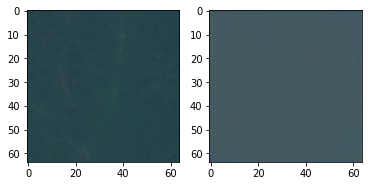

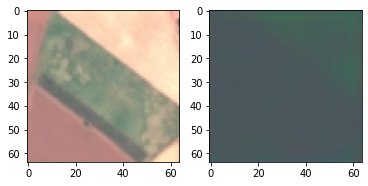

In [73]:
for i in range(20):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(test[i])
  plt.subplot(1,2,2)
  #img1[i][img1[i]>=0.35]=0.7

  plt.imshow(img1[i])

In [22]:
def create_model2():
  init_nb=16
  num_classes=3
  inputs = Input((64,64,3))
  down1 = Conv2D(init_nb, (3, 3), padding='same')(inputs)
  down1 = BatchNormalization()(down1)
  down1=MaxPooling2D(pool_size=(2,2))(down1)
  down1pool = Conv2D(init_nb, (3, 3), padding='same', strides=(2, 2))(down1)
  down1pool = BatchNormalization()(down1pool)
  down1pool = Activation('relu')(down1pool)
  down1pool=MaxPooling2D(pool_size=(2,2))(down1pool)

  down2 = Conv2D(init_nb * 2, (3, 3), padding='same')(down1pool)
  down2 = BatchNormalization()(down2)
  down2 = Activation('relu')(down2)
  down2pool = Conv2D(init_nb * 2, (3, 3), padding='same', strides=(2, 2))(down2)
  down2pool = BatchNormalization()(down2pool)
  down2pool = Activation('relu')(down2pool)
  down2pool=MaxPooling2D(pool_size=(2,2))(down2pool)


  down3 = Conv2D(init_nb * 4, (3, 3), padding='same')(down2pool)
  down3 = BatchNormalization()(down3)
  down3 = Activation('relu')(down3)
  down3pool = Conv2D(init_nb * 4, (3, 3), padding='same', strides=(2, 2))(down3)
  down3pool = BatchNormalization()(down3pool)
  down3pool = Activation('relu')(down3pool)

    
  up3 = Conv2DTranspose(init_nb*4,(3,3),padding='same',strides=(4,4))(down3pool)
  up3 = BatchNormalization()(up3)
  up3 = Activation('relu')(up3)
  up3 = Conv2D(init_nb * 4, (3, 3), padding='same')(up3)
  up3 = Conv2D(init_nb * 4, (3, 3), padding='same')(up3)
  up3 = BatchNormalization()(up3)
  up3 = Activation('relu')(up3)
  
  
  up3 = Conv2DTranspose(init_nb*2,(3,3),padding='same',strides=(2,2))(up3)
  up2 =UpSampling2D(size=(4,4))(up3)
  up2 = BatchNormalization()(up2)
  up2 = Activation('relu')(up2)
  up2 = Conv2D(init_nb * 2, (3, 3), padding='same')(up2)
  up2 = Conv2D(init_nb * 2, (3, 3), padding='same')(up2)
  up2 = BatchNormalization()(up2)
  up2 = Activation('relu')(up2)
    
  up1 = Conv2DTranspose(init_nb,(3,3),padding='same',strides=(2,2))(up2)
  up1 = BatchNormalization()(up1)
  up1 = Activation('relu')(up1)
  up1 = Conv2D(init_nb, (3, 3), padding='same')(up1)
  up1 = Conv2D(init_nb, (3, 3), padding='same')(up1)
  up1 = BatchNormalization()(up1)
  up1 = Activation('relu')(up1)
  classify = Conv2D(3, (1,1), activation='softmax')(up1)
  model1 = Model(inputs=inputs, outputs=classify)
  return model1


In [23]:

model2=create_model2()
model2.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization_24 (Batc (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 16)        2320      
_________________________________________________________________
batch_normalization_25 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
activation_22 (Activation)   (None, 16, 16, 16)        0   

In [24]:
model2.fit(X_train,X_train,batch_size=64,epochs=20,verbose=1)

Epoch 1/20
422/422 [==============================] - 14s 28ms/step - loss: 1.2991 - accuracy: 0.2610
Epoch 2/20
422/422 [==============================] - 12s 28ms/step - loss: 1.3105 - accuracy: 0.3658
Epoch 3/20
422/422 [==============================] - 12s 28ms/step - loss: 1.3290 - accuracy: 0.3625
Epoch 4/20
422/422 [==============================] - 12s 28ms/step - loss: 1.3416 - accuracy: 0.3672
Epoch 5/20
422/422 [==============================] - 12s 28ms/step - loss: 1.3433 - accuracy: 0.3861
Epoch 6/20
422/422 [==============================] - 12s 28ms/step - loss: 1.3389 - accuracy: 0.3873
Epoch 7/20
422/422 [==============================] - 12s 28ms/step - loss: 1.3326 - accuracy: 0.3878
Epoch 8/20
422/422 [==============================] - 12s 28ms/step - loss: 1.3188 - accuracy: 0.3944
Epoch 9/20
422/422 [==============================] - 12s 28ms/step - loss: 1.3097 - accuracy: 0.3898
Epoch 10/20
422/422 [==============================] - 12s 28ms/step - loss: 1.292

In [87]:
test2=X_train[:1000]
img2=model2.predict(test2)
img2

array([[[[0.30605525, 0.29303986, 0.40090486],
         [0.26025662, 0.37348363, 0.3662598 ],
         [0.25378585, 0.36903095, 0.3771832 ],
         ...,
         [0.2370348 , 0.3880945 , 0.37487063],
         [0.23715638, 0.3864966 , 0.37634706],
         [0.25704032, 0.35113955, 0.3918201 ]],

        [[0.24345663, 0.37813315, 0.3784102 ],
         [0.2446472 , 0.36905658, 0.38629615],
         [0.24665835, 0.36789018, 0.38545147],
         ...,
         [0.22745724, 0.3994924 , 0.37305033],
         [0.23502204, 0.39469442, 0.37028357],
         [0.23750542, 0.37105766, 0.39143687]],

        [[0.24008045, 0.37631893, 0.38360065],
         [0.2443099 , 0.36212596, 0.39356413],
         [0.24498777, 0.36907443, 0.38593775],
         ...,
         [0.24652354, 0.3843483 , 0.3691282 ],
         [0.23728321, 0.40063795, 0.36207882],
         [0.25246793, 0.37559107, 0.37194103]],

        ...,

        [[0.22506914, 0.41487604, 0.3600548 ],
         [0.23616578, 0.39065698, 0.37317726]

**Using convoloutin Trasnpose as upsampling**

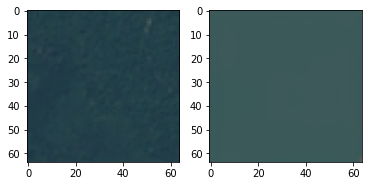

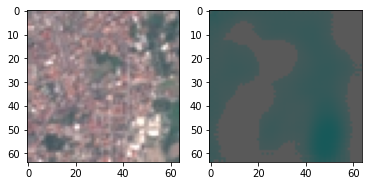

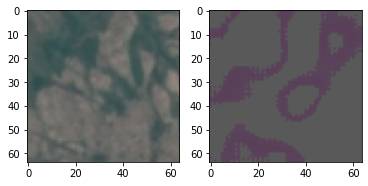

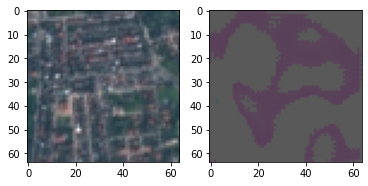

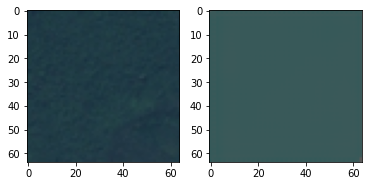

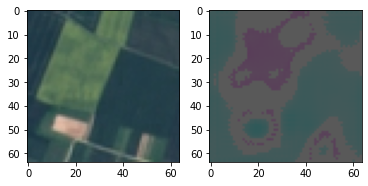

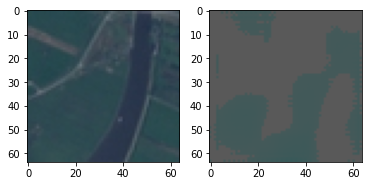

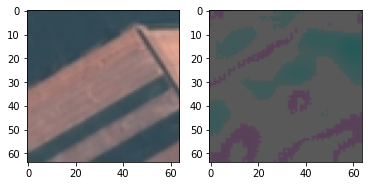

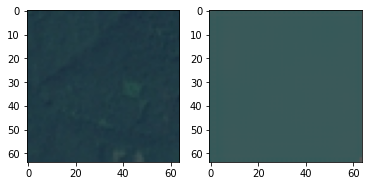

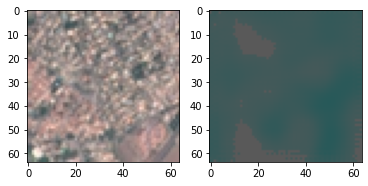

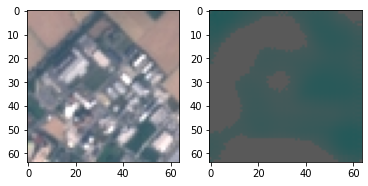

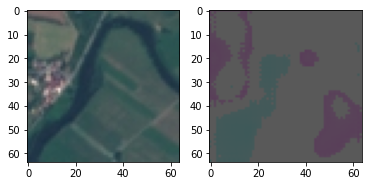

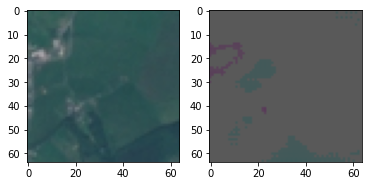

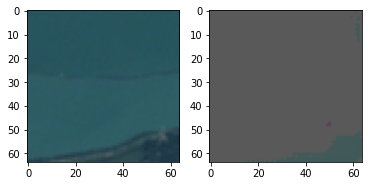

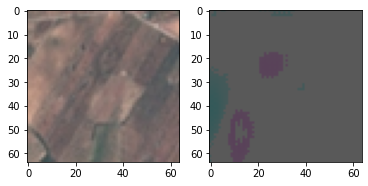

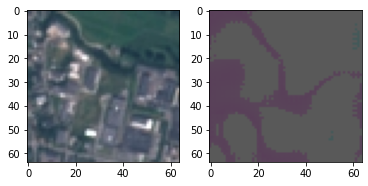

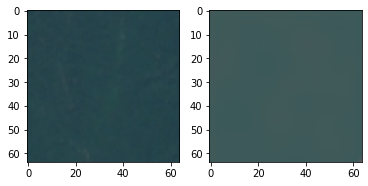

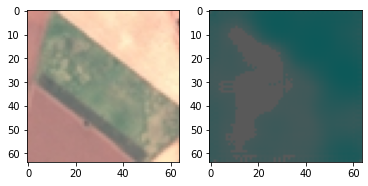

In [91]:
for i in range(20):
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(test2[i])
  plt.subplot(1,2,2)
  img2[i][img2[i]>=0.35]=0.6
  img2[i][img2[i]>=0.27]=0.35

  plt.imshow(img2[i])